In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # workaround, pode evitar crash

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
dataset = datasets.ImageFolder(root="data", transform=transform)

In [5]:
len(dataset)

3985

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

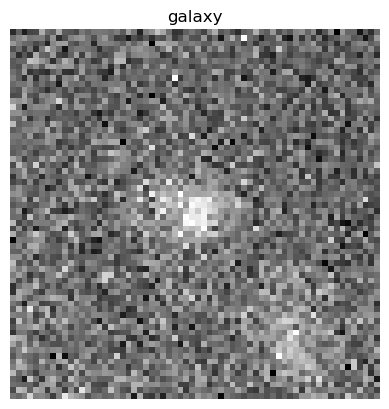

In [8]:
img, label = dataset[0]

plt.imshow(img.squeeze(0), cmap='gray')
plt.title(f"{dataset.classes[label]}")
plt.axis('off')

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

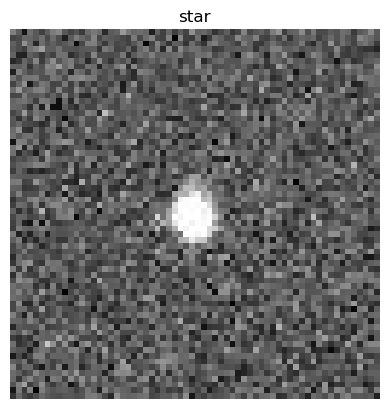

In [13]:
img, label = dataset[-1]

plt.imshow(img.squeeze(0), cmap='gray')
plt.title(f"{dataset.classes[label]}")
plt.axis('off')

In [4]:
dataloader_noNorm = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

In [5]:
total_sum = torch.zeros(1)
total_sqsum = torch.zeros(1)
total_pixels = 0

with torch.no_grad():
    for images, labels in dataloader_noNorm:
        b = images.shape[0]
        c = images.shape[1]
        h = images.shape[2]
        w = images.shape[3]

        sum_batch = torch.sum(images, dim=(0, 2, 3))
        sqsum_batch = torch.sum(images**2, dim=(0, 2, 3))
        pixels_batch = b * h * w

        total_sum += sum_batch
        total_sqsum += sqsum_batch
        total_pixels += pixels_batch

In [6]:
mean = total_sum / total_pixels
var = total_sqsum / total_pixels - mean**2
std = torch.sqrt(var)

print("Média: ", mean.item())
print("Desvio padrão: ", std.item())


Média:  0.3573446571826935
Desvio padrão:  0.14582973718643188


In [7]:
m = mean.item()
s = std.item()

In [32]:
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s])
])

In [33]:
val_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[m], std=[s])
])

In [34]:
dataset.classes

['galaxy', 'star']

In [35]:
train_dataset = datasets.ImageFolder(root='data', transform=train_transform)

In [36]:
totalsize = len(train_dataset)
train_size = int(0.7 * totalsize)
val_size = int(0.15 * totalsize)
test_size = totalsize - train_size - val_size

In [37]:
train_df, val_df, test_df = random_split(train_dataset,[train_size, val_size, test_size], torch.Generator().manual_seed(42))

In [38]:
train_loader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_df, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_df, batch_size=32, shuffle=False, num_workers=4)

In [39]:
print(f"Total: {len(train_df + val_df + test_df)}, Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Total: 3985, Train: 2789, Validation: 597, Test: 599


In [40]:
torch.manual_seed(42)
it_loader = iter(train_loader)

with torch.no_grad():
    images, labels = next(it_loader)
    mean_batch = images.mean(dim=(0, 2, 3))
    std_batch = images.std(dim=(0, 2, 3), unbiased=False)

    print(f"Média batch:  {mean_batch.item():.4f}")
    print(f"Desvio padrão batch: {std_batch.item():.4f}")

Média batch:  0.0726
Desvio padrão batch: 1.0696


In [41]:
print(images.min().item(), images.max().item())

-2.4504237174987793 4.406888484954834


In [ ]:
train_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1,
                 v2.)
])

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((8, 8))
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = CNN(num_classes=2)

dummy = torch.randn(1, 1, 150, 150)
out = model(dummy)

print("Output:", out.shape)

Output: torch.Size([1, 2])


In [22]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion  = nn.CrossEntropyLoss()

In [23]:
num_epochs = 10

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Geração [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acurácia: {epoch_acc:.2f}%")

Geração [1/10] Loss: 0.5948 Acurácia: 75.80%
Geração [2/10] Loss: 0.5377 Acurácia: 76.30%
Geração [3/10] Loss: 0.5291 Acurácia: 76.12%
Geração [4/10] Loss: 0.5252 Acurácia: 76.30%
Geração [5/10] Loss: 0.4894 Acurácia: 76.30%
Geração [6/10] Loss: 0.4232 Acurácia: 80.06%
Geração [7/10] Loss: 0.3681 Acurácia: 83.11%
Geração [8/10] Loss: 0.3412 Acurácia: 85.48%
Geração [9/10] Loss: 0.3309 Acurácia: 85.87%
Geração [10/10] Loss: 0.3211 Acurácia: 86.55%


In [24]:
class CNN_2(nn.Module):
    def __init__(self, num_classes):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.adative_pool = nn.AdaptiveMaxPool2d((12, 12))
        self.fc1 = nn.Linear(144 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adative_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
model = CNN_2(num_classes=2)

dummy = torch.randn(1, 1, 150, 150)
out = model(dummy)

print("Output:", out.shape)

Output: torch.Size([1, 2])


In [26]:
learning_rate = 0.01

In [27]:
num_epochs = 10

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Geração [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acurácia: {epoch_acc:.2f}%")

Geração [1/10] Loss: 0.6833 Acurácia: 76.30%
Geração [2/10] Loss: 0.6834 Acurácia: 76.30%
Geração [3/10] Loss: 0.6833 Acurácia: 76.30%
Geração [4/10] Loss: 0.6834 Acurácia: 76.30%
Geração [5/10] Loss: 0.6833 Acurácia: 76.30%
Geração [6/10] Loss: 0.6833 Acurácia: 76.30%
Geração [7/10] Loss: 0.6833 Acurácia: 76.30%
Geração [8/10] Loss: 0.6833 Acurácia: 76.30%
Geração [9/10] Loss: 0.6833 Acurácia: 76.30%
Geração [10/10] Loss: 0.6834 Acurácia: 76.30%
